In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysa.emd as emddev
import pysa.eemd as eemddev
import pysa.visualization as plotter
import pysa.utils as utils
from scipy import signal as sci_signal
import os
from numpy import arange, sin, pi
from scipy import interpolate

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams.update({'font.size': 14})

In [3]:
def notch_filter(input_signal):
    fs = 250.0  # Sample frequency (Hz)
    f0 = 50.0  # Frequency to be removed from signal (Hz)
    Q = 30.0  # Quality factor
    w0 = f0/(fs/2)  # Normalized Frequency
    # Design notch filter
    b, a = sci_signal.iirnotch(w0, Q)

    return sci_signal.filtfilt(b, a, input_signal)

In [4]:
def IMF_filter(signal, with_res=0):
    max_modes = 15
    ensembles = 100
    ensembles_per_process = 10
    max_siftings = 200
    end_time = 10
    sample_freq = 250

    max_data = max(signal)
    min_data = min(signal)
    
    imfs = emddev.emd(signal, min_data, max_data, max_modes, max_siftings)
    
    imf1 = utils.reverse_normalization(imfs[0], min_data, max_data, len(signal))
    imf2 = utils.reverse_normalization(imfs[1], min_data, max_data, len(signal))
    residue = utils.reverse_normalization(imfs[-1], min_data, max_data, len(signal))
    
    return signal - imf1 - residue * with_res

In [5]:
def get_IMF(signal, max_modes = 15):
    max_siftings = 200
    end_time = 10
    sample_freq = 250

    max_data = max(signal)
    min_data = min(signal)
    
    return emddev.emd(signal, min_data, max_data, max_modes, max_siftings)

In [22]:
red = (0.8, 0.2, 0.2)
blue = (0, 0, 0.6)
green = (0.1, 0.5, 0.1)

In [11]:
data[:, 0].shape

(1497,)

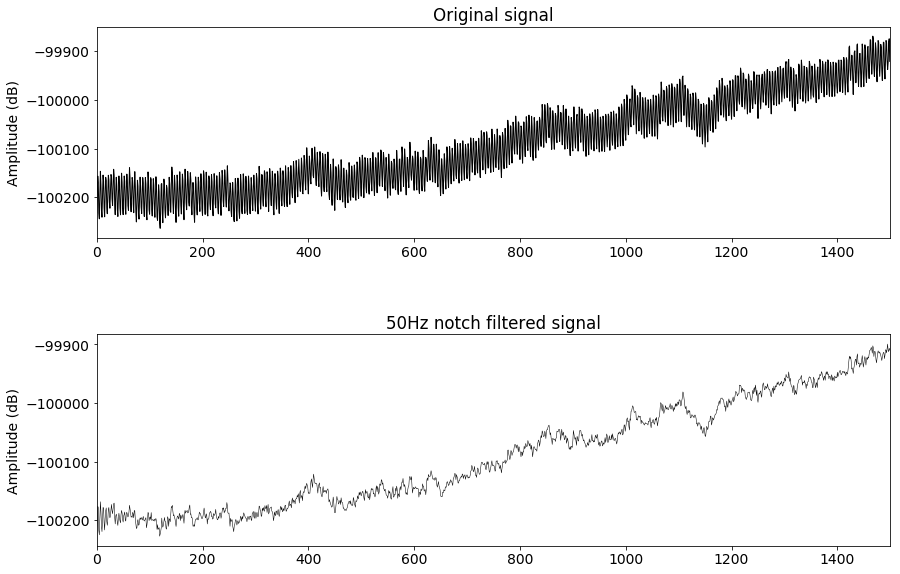

In [27]:
# Electrical noise filter plot
path = 'exp_data/test/left/'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)

df = pd.read_csv(os.path.join(path, files[1]), index_col=0)
data = df.as_matrix()

signal = data[:, 1]

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.tight_layout(h_pad=5)

line1 = ax[0].plot(signal, color='black')
plt.setp(line1, linewidth=1)
ax[0].set_title("Original signal")
ax[0].set_ylabel("Amplitude (dB)")
ax[0].set_xlim([0, len(signal)])
#ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
ax[0].grid(False)

line2 = ax[1].plot(notch_filter(signal), color='black')
plt.setp(line2, linewidth=0.5)
ax[1].set_title("50Hz notch filtered signal")
ax[1].set_ylabel("Amplitude (dB)")
ax[1].set_xlim([0, len(signal)])
#ax[1].spines['top'].set_visible(False)
#ax[1].spines['right'].set_visible(False)
ax[1].grid(False)

fig.savefig("plots/electrical_noise_notch.eps", format="eps")

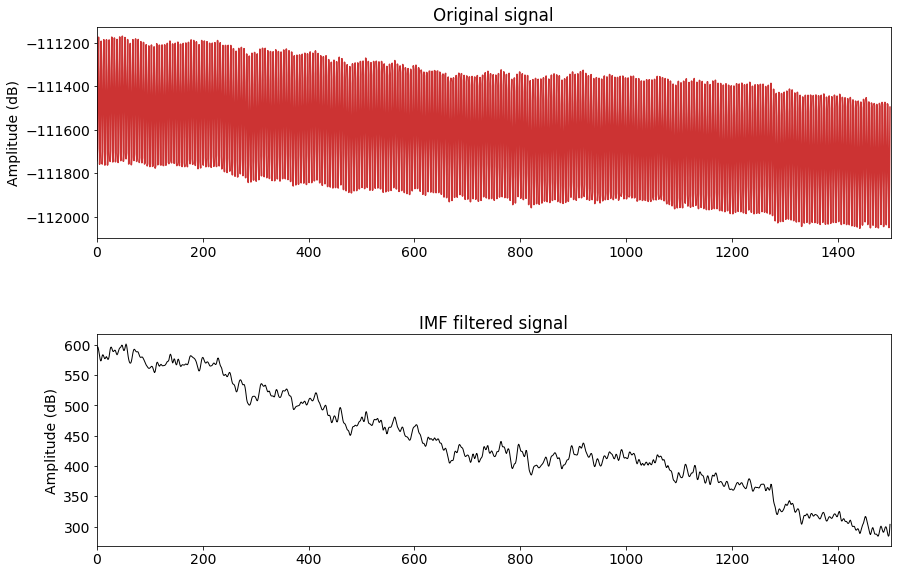

In [37]:
# IMF filter plot
path = 'Data/j_r_o_5/'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)

df = pd.read_csv(os.path.join(path, files[1]), index_col=0)
data = df.as_matrix()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.tight_layout(h_pad=5)

line1 = ax[0].plot(data[:,1], color=red)
plt.setp(line1, linewidth=1.5)
ax[0].set_title("Original signal")
ax[0].set_ylabel("Amplitude (dB)")
ax[0].set_xlim([0, len(data[:,1])])
#ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
ax[0].grid(False)

line2 = ax[1].plot(IMF_filter(data[:,1]), color="black")
plt.setp(line2, linewidth=1)
ax[1].set_title("IMF filtered signal")
ax[1].set_ylabel("Amplitude (dB)")
ax[1].set_xlim([0, len(data[:,1])])
#ax[1].spines['top'].set_visible(False)
#ax[1].spines['right'].set_visible(False)
ax[1].grid(False)

fig.savefig("plots/electrical_noise_IMF.eps", format="eps")

In [61]:
t = arange(0, 3, 0.001)

simple_sin = sin(20*pi * t)
simple_sin2 = sin(10*pi * t)
simple_sin3 = sin(5*pi * t)
signal = simple_sin + simple_sin2 + simple_sin3

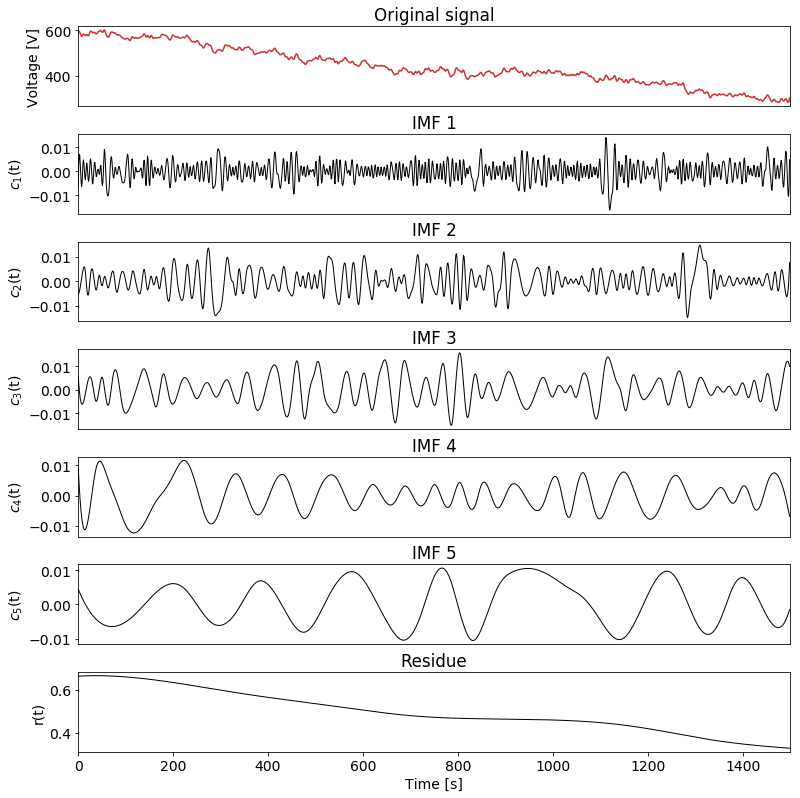

In [40]:
# IMF/EMD example
path = 'Data/j_r_o_5/'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)   
df = pd.read_csv(os.path.join(path, files[1]), index_col=0)
data = df.as_matrix()
signal = data[:,1]
imfs = get_IMF(signal)

fig, axis = plt.subplots(imfs.shape[0], 1, figsize=(12, 12))
fig.tight_layout(h_pad=0.1, pad=4)

line1 = axis[0].plot(IMF_filter(signal, 0), color=red)
plt.setp(line1, linewidth=1.5)
axis[0].set_title("Original signal")
axis[0].set_ylabel("Voltage [V]")
axis[0].set_xlim([0, imfs.shape[1]])
axis[0].get_xaxis().set_ticks([])
#ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
axis[0].grid(False)

for i, ax in enumerate(axis[1:]):
    is_last = (i == (len(axis[1:]) - 1))
    line1 = ax.plot(imfs[i + 1], color='black')
    if is_last:
        ax.set_title("Residue")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("r(t)")
    plt.setp(line1, linewidth=1)
    #ax.set_ylabel("Amplitude (dB)")
    ax.set_xlim([0, imfs.shape[1]])
    #ax[0].spines['top'].set_visible(False)
    #ax[0].spines['right'].set_visible(False)
    ax.grid(False)
    if not is_last:
        ax.get_xaxis().set_ticks([])
        ax.set_ylabel("$c_" + str(i + 1) + "$(t)")
        ax.set_title("IMF " + str(i + 1))


fig.savefig("plots/electrical_all_IMFs.eps", format="eps")

In [64]:
# IMF/EMD example
path = 'Data/j_r_o_5/'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)   
df = pd.read_csv(os.path.join(path, files[1]), index_col=0)
data = df.as_matrix()
signal = IMF_filter(data[:,1], 1)[150:300]

maxima = emddev.find_maxima(signal)
minima = emddev.find_minima(signal)

In [65]:
maxima_spline = emddev.interpolate_maxima(signal, maxima)
minima_spline = emddev.interpolate_minima(signal, minima)
mean_signal = emddev.find_local_mean(minima_spline, maxima_spline)

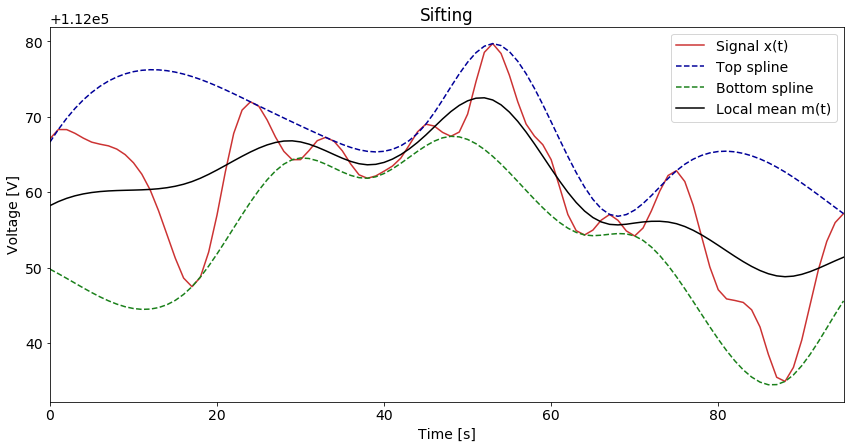

In [66]:
fig, axis = plt.subplots(1, 1, figsize=(12, 6))
fig.tight_layout(h_pad=0.1)

line1, = axis.plot(signal[26:-28], color=red, linewidth=1.5, label="Signal x(t)")
line2, = axis.plot(maxima_spline[26:-28], color=blue, linestyle="--", label="Top spline")
line3, = axis.plot(minima_spline[26:-28], color=green, linestyle="--", label="Bottom spline")
line4, = axis.plot(mean_signal[26:-28], color="black", label="Local mean m(t)")
plt.legend(handles=[line1, line2, line3, line4])
axis.set_title("Sifting")
axis.set_ylabel("Voltage [V]")
axis.set_xlabel("Time [s]")
axis.set_xlim([0, signal.shape[0] - 54 - 1])
#ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
axis.grid(False)


fig.savefig("plots/spline_example.eps", format="eps")